# Personalized Spotify Playlist Generator: A Music Recommendation System

This project builds a personalized music recommendation system by clustering songs based on their audio features. It enhances music discovery by blending familiar favorites with new recommendations tailored to individual listening patterns.

# Business Understanding

Problem: With millions of songs available on streaming platforms like Spotify, users often struggle to discover new music that aligns with their personal taste. While Spotify provides curated playlists, these are often based on generalized trends rather than a user's unique listening patterns. Many users rely on manually creating playlists, which can be time-consuming and limited in scope.This project solves this problem by using data-driven clustering to group songs based on musical characteristics. By leveraging machine learning techniques, we can identify patterns in a user's listening history and generate highly personalized playlists that introduce new songs while maintaining familiarity with their existing favorites.

Stakeholder: Spotify Users
* Get automated personalized playlists based on listening history and preferences.
* Discover new songs that align with their taste, reducing the need for manual curation.
* Improve their overall music experience with better recommendations.

By implementing clustering-based personalized recommendations, this system ensures users automatically generate playlists tailored to their listening habits while still introducing variety. Unlike Spotify’s existing recommendation models, which often favor popular songs, this approach diversifies song discovery while keeping recommendations aligned with user preferences.

# Data Understanding

1. Extracting My Top 2000 Songs
* Using Spotify's API and the Spotipy library, I retrieved my top 2000 most-listened-to songs.
* See notebook "creating_spotify_dataset.ipynb" for more details.
* Here is documentation on the **[Spotify API](https://developer.spotify.com/documentation/web-api)**.

2. 1.2M Spotify Songs Kaggle Dataset
* The dataset used in this project is sourced from **[Kaggle - Spotify 12M Songs](https://www.kaggle.com/datasets/rodolfofigueroa/spotify-12m-songs)**. 
* Contains audio features for over 1.2 million songs, obtained with the Spotify API.

3. Final Dataset: "songs.csv"
* 1,204,025 rows and 25 columns
* To integrate my top songs into this dataset, I added a binary column (in_top_tracks) indicating whether each song in the Kaggle dataset was part of my top 2000 songs.

## Feature Selection & Justification
The dataset contains a variety of song attributes, including audio features, metadata, and user-specific information. The features included were chosen based on their relevance for clustering and personalized recommendations:

Musical Characteristics (Key Features for Clustering):
* danceability: Measures how suitable a track is for dancing, helping to differentiate between high-energy and low-energy songs.
energy: Captures the intensity and activity level of a song.
* valence: Indicates how positive or negative a song sounds, helping to cluster songs based on mood.
* tempo: Beats per minute (BPM), useful for identifying fast vs. slow songs.
* loudness: Differentiates between soft acoustic songs and high-energy tracks.
* speechiness: Helps distinguish spoken-word tracks (e.g., podcasts, rap) from instrumental music.
* acousticness: Determines if a song is acoustic or electronic, useful for genre-based clustering.
* instrumentalness: Helps separate instrumental tracks from songs with vocals.
* liveness: Identifies live vs. studio-recorded performances.

User-Specific Features for Personalization:
* in_top_tracks: A binary indicator (1/0) denoting whether the song appears in the user’s top songs. This feature helps prioritize songs the user already likes while generating recommendations.
By selecting these features, we ensure that the clustering model captures meaningful differences between songs, leading to more personalized and relevant playlist recommendations.

### Limitations of the Data:
1. Lack of Contextual Listening Data: The dataset does not include time-based or situational listening behavior (e.g., what songs are played in the morning vs. at night). This limits our ability to create playlists for specific moods or activities beyond what the audio features suggest.
2. Potential Data Bias: Since the dataset includes user’s top tracks, recommendations may reinforce existing preferences rather than encouraging musical discovery. Songs that were never played by the user might not be considered, limiting exploration.
3. Genre Representation Imbalance: Some genres may be overrepresented or underrepresented, leading to clusters that are skewed toward dominant genres.This could impact recommendations if the user's favorite genres are underrepresented.
4. Spotify's Feature Limitations: Audio features like danceability and valence are not subjective and are determined by Spotify’s algorithm. Some nuances of music perception (e.g., personal emotional response to a song) cannot be captured directly from this dataset.
5. Song Feature Availability: Since Spotify no longer provides musical characteristics of songs, the top tracks had to be referenced with a pre-existing dataset that did not include all 2000 of the top tracks used in this analysis.

### Implications for the Project:
* To improve recommendations, future iterations could incorporate collaborative filtering by analyzing what similar users listen to.
* Adding user feedback mechanisms (e.g., ratings for recommendations) would allow the system to refine future suggestions.
* Including external metadata (e.g., genre tags, lyrics analysis) could help improve song clustering and personalization.

### Key Metrics:
* Cosine Similarity measures how similar two vectors (e.g., song feature embeddings) are by computing the cosine of the angle between them. A value close to 1 indicates that the vectors (songs) are very similar, while a value close to 0 means they are highly dissimilar. This is particularly useful for music recommendation systems because it considers the relative importance of features rather than their absolute differences, making it robust to variations in scale.
* Silhouette Score evaluates the quality of clustering by measuring how well-separated and cohesive clusters are. It ranges from -1 to 1, where a higher score suggests that points are well-clustered with their assigned group and far from other clusters.
* Key Metric: Cosine Similarity
Since song features are high-dimensional and their absolute values may not be as meaningful, cosine similarity is a better fit than Euclidean distance for clustering. It ensures that we capture the true "closeness" of songs based on their feature relationships rather than raw distances. This is particularly effective when building a personalized playlist, as it prioritizes recommendations that are most aligned with a user's listening patterns.

In [4]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning) 
warnings.simplefilter("ignore", category=DeprecationWarning)

In [5]:
df=pd.read_csv('./data/songs.csv')
df

,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,danceability,...,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,release_date,in_top_tracks
0,7lmeHLHBe4nmXzuXc0HDjk,Testify,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],1,1,False,0.470,...,0.02610,0.000011,0.3560,0.503,117.906,210133,4.0,1999,1999-11-02,0
1,1wsRitfRRtWyEapl0q22o8,Guerrilla Radio,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],2,1,True,0.599,...,0.01290,0.000071,0.1550,0.489,103.680,206200,4.0,1999,1999-11-02,0
2,1hR0fIFK2qRG3f3RF70pb7,Calm Like a Bomb,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],3,1,False,0.315,...,0.02340,0.000002,0.1220,0.370,149.749,298893,4.0,1999,1999-11-02,0
3,2lbASgTSoDO7MTuLAXlTW0,Mic Check,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],4,1,True,0.440,...,0.16300,0.000004,0.1210,0.574,96.752,213640,4.0,1999,1999-11-02,0
4,1MQTmpYOZ6fcMQc56Hdo7T,Sleep Now In the Fire,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],5,1,False,0.426,...,0.00162,0.105000,0.0789,0.539,127.059,205600,4.0,1999,1999-11-02,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1204020,0EsMifwUmMfJZxzoMPXJKZ,Gospel of Juke,Notch - EP,38O5Ys0W9PFS5K7dMb7yKb,['FVLCRVM'],['7AjItKsRnEYRSiBt2OxK1y'],2,1,False,0.264,...,0.00935,0.002240,0.3370,0.415,159.586,276213,4.0,2014,2014-01-09,0
1204021,2WSc2TB1CSJgGE0PEzVeiu,Prism Visions,Notch - EP,38O5Ys0W9PFS5K7dMb7yKb,['FVLCRVM'],['7AjItKsRnEYRSiBt2OxK1y'],3,1,False,0.796,...,0.10400,0.644000,0.0749,0.781,121.980,363179,4.0,2014,2014-01-09,0
1204022,6iProIgUe3ETpO6UT0v5Hg,Tokyo 360,Notch - EP,38O5Ys0W9PFS5K7dMb7yKb,['FVLCRVM'],['7AjItKsRnEYRSiBt2OxK1y'],4,1,False,0.785,...,0.03040,0.918000,0.0664,0.467,121.996,385335,4.0,2014,2014-01-09,0
1204023,37B4SXC8uoBsUyKCWnhPfX,Yummy!,Notch - EP,38O5Ys0W9PFS5K7dMb7yKb,['FVLCRVM'],['7AjItKsRnEYRSiBt2OxK1y'],5,1,False,0.665,...,0.00007,0.776000,0.1170,0.227,124.986,324455,4.0,2014,2014-01-09,0


In [6]:
df.columns

Index(['id', 'name', 'album', 'album_id', 'artists', 'artist_ids',
       'track_number', 'disc_number', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature', 'year', 'release_date', 'in_top_tracks'],
      dtype='object')

In [7]:
df.shape

(1204025, 25)

In [8]:
df.describe()

,track_number,disc_number,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,in_top_tracks
count,1.204025e+06,1.204025e+06,1.204025e+06,1.204025e+06,1.204025e+06,1.204025e+06,1.204025e+06,1.204025e+06,1.204025e+06,1.204025e+06,1.204025e+06,1.204025e+06,1.204025e+06,1.204025e+06,1.204025e+06,1.204025e+06,1.204025e+06
mean,7.656352e+00,1.055906e+00,4.930565e-01,5.095363e-01,5.194151e+00,-1.180870e+01,6.714595e-01,8.438219e-02,4.467511e-01,2.828605e-01,2.015994e-01,4.279866e-01,1.176344e+02,2.488399e+05,3.832494e+00,2.007328e+03,1.171072e-04
std,5.994977e+00,2.953752e-01,1.896694e-01,2.946839e-01,3.536731e+00,6.982132e+00,4.696827e-01,1.159914e-01,3.852014e-01,3.762844e-01,1.804591e-01,2.704846e-01,3.093705e+01,1.622104e+05,5.611826e-01,1.210117e+01,1.082098e-02
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+03,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,1.000000e+00,3.560000e-01,2.520000e-01,2.000000e+00,-1.525400e+01,0.000000e+00,3.510000e-02,3.760000e-02,7.600000e-06,9.680000e-02,1.910000e-01,9.405400e+01,1.740900e+05,4.000000e+00,2.002000e+03,0.000000e+00
50%,7.000000e+00,1.000000e+00,5.010000e-01,5.240000e-01,5.000000e+00,-9.791000e+00,1.000000e+00,4.460000e-02,3.890000e-01,8.080000e-03,1.250000e-01,4.030000e-01,1.167260e+02,2.243390e+05,4.000000e+00,2.009000e+03,0.000000e+00
75%,1.000000e+01,1.000000e+00,6.330000e-01,7.660000e-01,8.000000e+00,-6.717000e+00,1.000000e+00,7.230000e-02,8.610000e-01,7.190000e-01,2.450000e-01,6.440000e-01,1.370460e+02,2.858400e+05,4.000000e+00,2.015000e+03,0.000000e+00
max,5.000000e+01,1.300000e+01,1.000000e+00,1.000000e+00,1.100000e+01,7.234000e+00,1.000000e+00,9.690000e-01,9.960000e-01,1.000000e+00,1.000000e+00,1.000000e+00,2.489340e+02,6.061090e+06,5.000000e+00,2.020000e+03,1.000000e+00


In [9]:
df.in_top_tracks.value_counts()

in_top_tracks
0    1203884
1        141
Name: count, dtype: int64

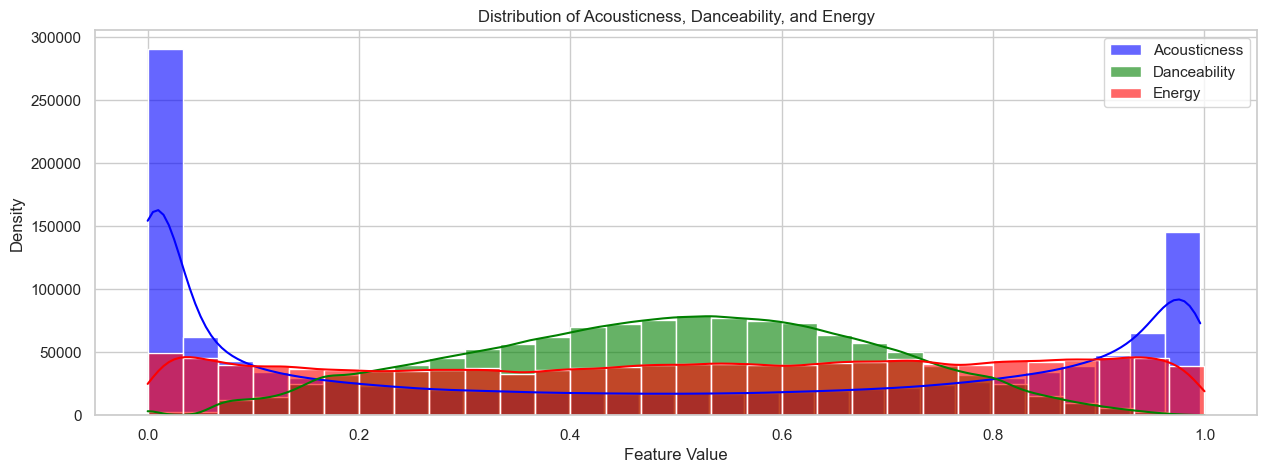

In [10]:
# Set visualization style
sns.set(style="whitegrid")

# Plot distributions
plt.figure(figsize=(15, 5))
sns.histplot(df["acousticness"], bins=30, kde=True, color="blue", label="Acousticness", alpha=0.6)
sns.histplot(df["danceability"], bins=30, kde=True, color="green", label="Danceability", alpha=0.6)
sns.histplot(df["energy"], bins=30, kde=True, color="red", label="Energy", alpha=0.6)
plt.legend()
plt.title("Distribution of Acousticness, Danceability, and Energy")
plt.xlabel("Feature Value")
plt.ylabel("Density")
plt.show()

### Visualize Distribution of Artists and Songs

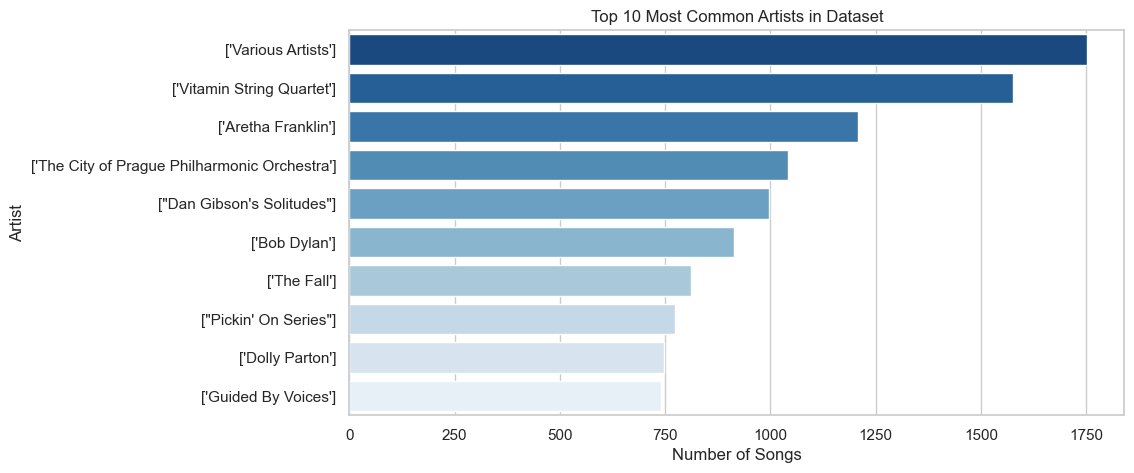

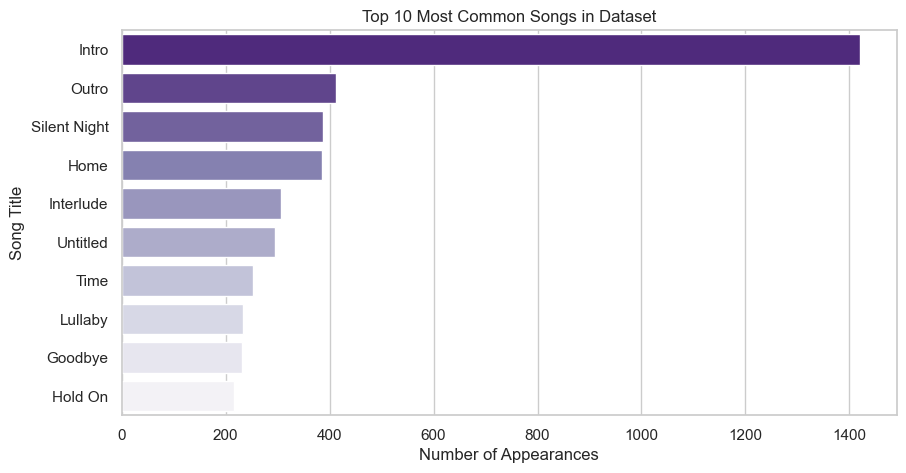

In [11]:
# Count top 10 most common artists
top_artists = df["artists"].value_counts().head(10)

# Count top 10 most common songs
top_songs = df["name"].value_counts().head(10)

# Plot top 10 artists
plt.figure(figsize=(10, 5))
sns.barplot(y=top_artists.index, x=top_artists.values, palette="Blues_r")
plt.title("Top 10 Most Common Artists in Dataset")
plt.xlabel("Number of Songs")
plt.ylabel("Artist")
plt.show()

# Plot top 10 songs
plt.figure(figsize=(10, 5))
sns.barplot(y=top_songs.index, x=top_songs.values, palette="Purples_r")
plt.title("Top 10 Most Common Songs in Dataset")
plt.xlabel("Number of Appearances")
plt.ylabel("Song Title")
plt.show()


# Data Preparation

Before applying clustering and recommendation techniques, we performed several data preprocessing steps to ensure the dataset was clean, structured, and ready for analysis. These steps included:

1. Data Cleaning & Handling Missing Values:
Removed unnecessary columns such as track_number, disc_number, and year, which were not relevant to clustering.
Checked for missing values and handled them appropriately:
For numerical features: Filled missing values with the mean or median.
For categorical features: Dropped or replaced missing values where necessary.
2. Feature Selection:
Selected relevant audio features for clustering, such as:
danceability, energy, valence, tempo, loudness, speechiness, acousticness, instrumentalness, and liveness.
Excluded non-numeric and non-informative features (e.g., id, name, album, artists) to focus only on musical attributes.
3. Feature Scaling:
Applied Standardization (Z-score normalization) using StandardScaler to ensure all features had a mean of 0 and standard deviation of 1. This prevented features with larger numerical ranges (like tempo and loudness) from dominating the clustering algorithm.

### Drop Duration, Track Number, Disc Number, Explicit and Year

In [12]:
# Drop unnecessary columns
df = df.drop(columns=["duration_ms", "track_number", "disc_number", "year","explicit"], errors="ignore")

### Correlation between features

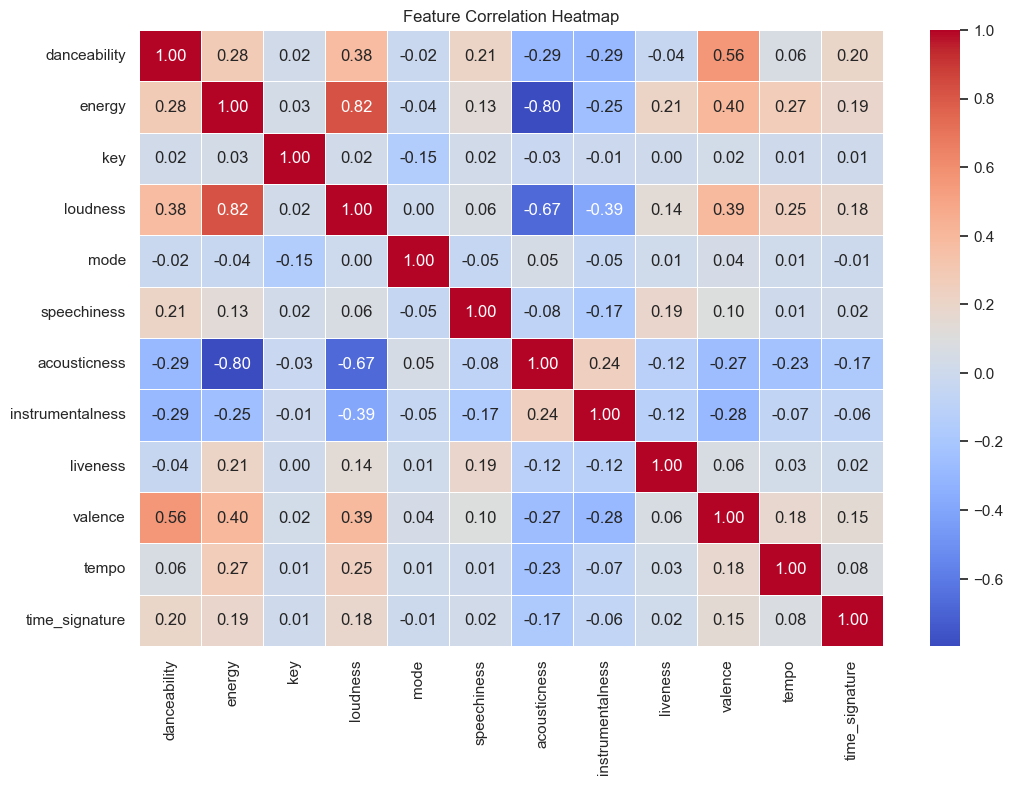

In [13]:
# Exclude "Unnamed: 0" and "in_top_tracks" and select only numeric columns
numeric_df = df.drop(columns=["Unnamed: 0", "in_top_tracks"], errors="ignore").select_dtypes(include=['number'])

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

### Drop Energy column
Since energy and loudness are highly correlated and energy and acousticness are highly correlated, I will drop energy as we are already getting similar information from the other features.

In [14]:
# Drop energy
df = df.drop(columns=["energy"], errors="ignore")

### Check for null values

In [15]:
# Check for missing values
df.isnull().sum()

id                   0
name                 3
album               11
album_id             0
artists              0
artist_ids           0
danceability         0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
time_signature       0
release_date         0
in_top_tracks        0
dtype: int64

In [16]:
# Drop rows with any null values
df.dropna(inplace=True)

# Verify that there are no more missing values
print(df.isnull().sum())

id                  0
name                0
album               0
album_id            0
artists             0
artist_ids          0
danceability        0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
release_date        0
in_top_tracks       0
dtype: int64


### Drop duplicate songs
It looks like there are some duplicate songs in the data set. We will keep only one version if it has the same title and artist.

In [17]:
# Drop duplicate songs/ remixes
df = df.drop_duplicates(subset=["name", "artist_ids"], keep="first").reset_index(drop=True)

In [18]:
#Check if there are any more duplicates
df.duplicated(subset=["name", "artist_ids"], keep=False).sum()

0

In [19]:
df.shape

(1141708, 19)

### Select only the features we will use for clustering

In [20]:
df.columns

Index(['id', 'name', 'album', 'album_id', 'artists', 'artist_ids',
       'danceability', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'release_date', 'in_top_tracks'],
      dtype='object')

In [21]:
df.in_top_tracks.value_counts()

in_top_tracks
0    1141600
1        108
Name: count, dtype: int64

In [22]:
df.head()

,id,name,album,album_id,artists,artist_ids,danceability,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_date,in_top_tracks
0,7lmeHLHBe4nmXzuXc0HDjk,Testify,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],0.470,7,-5.399,1,0.0727,0.02610,0.000011,0.3560,0.503,117.906,4.0,1999-11-02,0
1,1wsRitfRRtWyEapl0q22o8,Guerrilla Radio,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],0.599,11,-5.764,1,0.1880,0.01290,0.000071,0.1550,0.489,103.680,4.0,1999-11-02,0
2,1hR0fIFK2qRG3f3RF70pb7,Calm Like a Bomb,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],0.315,7,-5.424,1,0.4830,0.02340,0.000002,0.1220,0.370,149.749,4.0,1999-11-02,0
3,2lbASgTSoDO7MTuLAXlTW0,Mic Check,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],0.440,11,-5.830,0,0.2370,0.16300,0.000004,0.1210,0.574,96.752,4.0,1999-11-02,0
4,1MQTmpYOZ6fcMQc56Hdo7T,Sleep Now In the Fire,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],0.426,2,-6.729,1,0.0701,0.00162,0.105000,0.0789,0.539,127.059,4.0,1999-11-02,0


Features to Exclude
Metadata like id, name, album, artist_ids, release_date (Not useful for clustering).
Track structure details (track_number, disc_number) (Not indicative of song similarity).
Explicit content (explicit) (Doesn't indicate musical similarity).
Key & Mode (Not always helpful in clustering since many songs share the same key).

### Separate into liked and unheard songs

In [23]:
# Separate liked and unheard songs
liked_songs = df[df['in_top_tracks'] == 1]
unheard_songs = df[df['in_top_tracks'] == 0]

### Reduce Sample from 200K to 50K Unheard Songs to Improve Speed

In [24]:
sampled_unheard_songs = unheard_songs.sample(n=50000, random_state=42) if len(unheard_songs) > 50000 else unheard_songs
df_sample = pd.concat([liked_songs, sampled_unheard_songs])

In [25]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50108 entries, 33826 to 422776
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                50108 non-null  object 
 1   name              50108 non-null  object 
 2   album             50108 non-null  object 
 3   album_id          50108 non-null  object 
 4   artists           50108 non-null  object 
 5   artist_ids        50108 non-null  object 
 6   danceability      50108 non-null  float64
 7   key               50108 non-null  int64  
 8   loudness          50108 non-null  float64
 9   mode              50108 non-null  int64  
 10  speechiness       50108 non-null  float64
 11  acousticness      50108 non-null  float64
 12  instrumentalness  50108 non-null  float64
 13  liveness          50108 non-null  float64
 14  valence           50108 non-null  float64
 15  tempo             50108 non-null  float64
 16  time_signature    50108 non-null  float6

### Scale features

In [26]:
# Select relevant features for clustering
feature_cols = ['danceability', 'valence', 'tempo', 'acousticness',
                'instrumentalness', 'liveness', 'speechiness', 'loudness']

In [27]:
df_clustering = df_sample[feature_cols]

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clustering)

In [28]:
df_scaled.shape

(50108, 8)

# Modeling

KMeans
Agglomerative
DBSCAN
GMM

### Finding Optimal Number of Clusters for KMeans
The Elbow Method is a technique used to determine the ideal number of clusters (k) for K-Means clustering. It helps identify the point where adding more clusters does not significantly improve the clustering performance.

Inertia represents the sum of squared distances between each data point and its assigned cluster center.
Lower inertia indicates that data points are closer to their assigned cluster centers, which suggests better-defined clusters.
However, as k increases, inertia always decreases because clusters become smaller and tighter.

k=2, Inertia=304832.02621267375
k=3, Inertia=273143.66998522315
k=4, Inertia=241992.57463593478
k=5, Inertia=223240.93439815825
k=6, Inertia=200294.59412298363
k=7, Inertia=189705.94310739703
k=8, Inertia=176921.37525162764
k=9, Inertia=167655.88381957353
k=10, Inertia=163759.91898355936


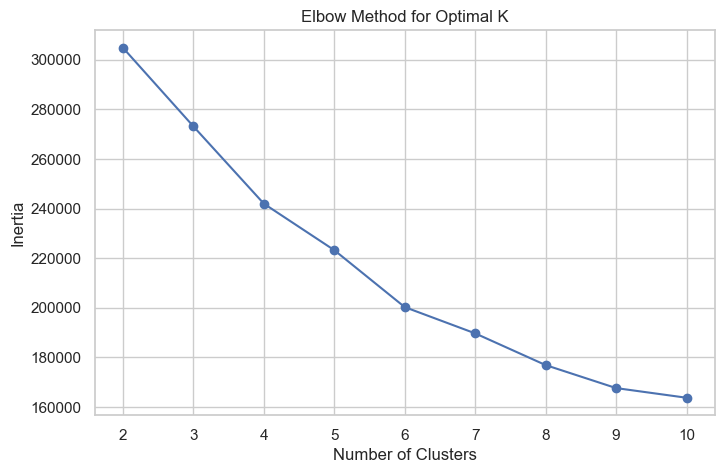

In [29]:
# Determine optimal number of clusters using Elbow method
inertia = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto', algorithm='elkan')
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)
    print(f'k={k}, Inertia={kmeans.inertia_}')  # Print inertia values

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

The largest inertia reductions occur between 𝑘=2 and 𝑘=6. After k=6, the decrease becomes much smaller.
At k=7 and beyond, the rate of improvement slows down significantly (diminishing returns). The best choice for k is 6, as it is the last point before diminishing returns.

### KMeans - 6 clusters

In [30]:
# Set optimal k
optimal_k = 6

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
cluster_labels=kmeans.fit_predict(df_scaled)
cluster_centers = kmeans.cluster_centers_ 

### Function to Evaluate Clustering (Compute Silhouette & Cosine Similarity Scores)

In [31]:
def evaluate_clustering(df_scaled, cluster_labels, cluster_centers, sample_size=2000):
    """
    Calculate the Silhouette Score and Cosine Similarity Score for clustering results.
    
    Parameters:
    - df_scaled: Scaled feature matrix (numpy array)
    - cluster_labels: Cluster assignments for each song
    - cluster_centers: Centroids of the clusters
    - sample_size: Number of samples for Silhouette Score computation (default=2000)
    
    Returns:
    - silhouette_avg: Average Silhouette Score (computed on a sample)
    - avg_cosine_similarity: Average Cosine Similarity Score (computed in bulk)
    """

    # Compute Silhouette Score on a smaller sample for efficiency
    if len(set(cluster_labels)) > 1:
        sample_size = min(sample_size, len(df_scaled))  # Ensure sample is within dataset size
        sample_indices = np.random.choice(len(df_scaled), size=sample_size, replace=False)
        silhouette_avg = silhouette_score(df_scaled[sample_indices], cluster_labels[sample_indices])
    else:
        silhouette_avg = None  # Silhouette is not defined for a single cluster

    # Compute Cosine Similarity in bulk (no looping)
    cosine_matrix = cosine_similarity(df_scaled, cluster_centers)
    
    # Get max similarity score for each song (closest centroid)
    avg_cosine_similarity = np.mean(np.max(cosine_matrix, axis=1))

    return silhouette_avg, avg_cosine_similarity

### Evaluate KMeans - 6 clusters

In [32]:
silhouette_score_kmeans, cosine_similarity_kmeans = evaluate_clustering(
    df_scaled,  # Scaled feature matrix
    kmeans.labels_,  # Directly use KMeans labels instead of a dataframe column
    kmeans.cluster_centers_
)

print(f"Silhouette Score for K-Means: {silhouette_score_kmeans:.4f}")
print(f"Cosine Similarity Score for K-Means: {cosine_similarity_kmeans:.4f}")

Silhouette Score for K-Means: 0.1799
Cosine Similarity Score for K-Means: 0.6915


In [33]:
# Initialize a results list if it doesn't exist
try:
    clustering_results
except NameError:
    clustering_results = []

# Store results for Kmeans:6 
kmeans_results_6 = {
    "Method": "K-Means",
    "Optimal k": optimal_k,
    "Silhouette Score": silhouette_score_kmeans,
    "Average Cosine Similarity": cosine_similarity_kmeans
}

# Append results to the list
clustering_results.append(kmeans_results_6)

### KMeans - 7 clusters

In [34]:
# Set optimal k
optimal_k = 7

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
kmeans.fit_predict(df_scaled)

array([0, 5, 1, ..., 4, 0, 1])

In [35]:
silhouette_score_kmeans, cosine_similarity_kmeans = evaluate_clustering(
    df_scaled,  # Scaled feature matrix
    kmeans.labels_,  # Directly use KMeans labels instead of a dataframe column
    kmeans.cluster_centers_
)

print(f"Silhouette Score for K-Means: {silhouette_score_kmeans:.4f}")
print(f"Cosine Similarity Score for K-Means: {cosine_similarity_kmeans:.4f}")

Silhouette Score for K-Means: 0.1912
Cosine Similarity Score for K-Means: 0.6978


In [36]:
# Store results for Kmeans: 7
kmeans_results_7 = {
    "Method": "K-Means",
    "Optimal k": optimal_k,
    "Silhouette Score": silhouette_score_kmeans,
    "Average Cosine Similarity": cosine_similarity_kmeans
}

# Append results to the list
clustering_results.append(kmeans_results_7)

### Gaissian Mixture Models (GMM)
Gaussian Mixture Models (GMM) is a probabilistic clustering method that assumes data is generated from a mixture of multiple Gaussian distributions. Unlike K-Means, which assigns each point to a single cluster, GMM provides soft clustering, meaning each point has a probability of belonging to multiple clusters. The Bayesian Information Criterion (BIC) is a metric used to evaluate GMM models by balancing model complexity and fit. A lower BIC score indicates a better trade-off between model accuracy and simplicity, helping to determine the optimal number of clusters while avoiding overfitting.

In [37]:
 # Test from 3 to 30 clusters
bic_scores = {}

for k in range(3, 30):
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(df_scaled)
    print(f"k={k}, BIC: {gmm.bic(df_scaled)}")
    bic = gmm.bic(df_scaled)
    bic_scores[k] = bic  # Store BIC for each

k=3, BIC: 864573.5269719646
k=4, BIC: 683951.7028941789
k=5, BIC: 648643.6362909932
k=6, BIC: 595445.9510116206
k=7, BIC: 589110.3709985431
k=8, BIC: 569366.7955007722
k=9, BIC: 554738.1660983053
k=10, BIC: 551517.3952707739
k=11, BIC: 539550.9083025283
k=12, BIC: 532343.5148763215
k=13, BIC: 525548.4719272761
k=14, BIC: 524311.6320918824
k=15, BIC: 515670.764918359
k=16, BIC: 513540.77892834326
k=17, BIC: 510406.9222926343
k=18, BIC: 501586.9617547422
k=19, BIC: 498425.16908675584
k=20, BIC: 493325.90853197925
k=21, BIC: 492303.5696123303
k=22, BIC: 491574.85787609196
k=23, BIC: 490734.88514158496
k=24, BIC: 487447.8057233143
k=25, BIC: 484699.8024422687
k=26, BIC: 477177.5874355819
k=27, BIC: 477493.6266775823
k=28, BIC: 477737.57603668363
k=29, BIC: 473218.7212410415


In [38]:
# Find the k with the lowest BIC
optimal_k = min(bic_scores, key=bic_scores.get)
best_bic = bic_scores[optimal_k]

# Print only the best k and BIC score
print(f"Optimal k={optimal_k}, Lowest BIC: {best_bic:.4f}")

Optimal k=29, Lowest BIC: 473218.7212


In [39]:
# Fit GMM with the optimal number of clusters
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
labels = gmm.fit_predict(df_scaled)

# GMM cluster "centers" are the means of each Gaussian component
cluster_centers = gmm.means_

# Evaluate clustering performance using your function
silhouette_avg, avg_cosine_similarity = evaluate_clustering(df_scaled, labels, cluster_centers)

# Display results
print(f"Optimal k={optimal_k}")
print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Average Cosine Similarity: {avg_cosine_similarity:.4f}")

Optimal k=29
Silhouette Score: -0.0579
Average Cosine Similarity: 0.7816


* The low Silhouette Score suggests that clusters might not be well-separated, potentially due to high overlap in song features.
* The high cosine similarity indicates that the songs within each cluster are quite similar, which is desirable for a recommendation system.

#### Store results

In [40]:
# Store results for GMM
gmm_results = {
    "Method": "GMM",
    "Optimal k": optimal_k,
    "Silhouette Score": silhouette_avg,
    "Average Cosine Similarity": avg_cosine_similarity
}

# Append results to the list
clustering_results.append(gmm_results)

### Try Agglomerative Clustering instead of KMeans
Agglomerative Clustering is a bottom-up hierarchical clustering method that starts with each data point as its own cluster and iteratively merges the most similar clusters based on a chosen distance metric until a stopping criterion is met. It offers different linkage methods, including single, complete, average, and Ward’s linkage, which determine how distances between clusters are measured. A key advantage is that it does not require specifying the number of clusters beforehand, allowing for natural hierarchical structures to emerge, often visualized using a dendrogram. However, it is computationally expensive, making it less suitable for large datasets compared to K-Means or Gaussian Mixture Models (GMM). Despite this, agglomerative clustering is valuable for song recommendation systems as it groups similar songs without enforcing predefined categories, preserving the natural relationships within the data.

In [41]:
# Sample dataset for Agglomerative Clustering
sample_size = min(10000, len(df_scaled))
df_scaled_sample = df_scaled[np.random.choice(len(df_scaled), size=sample_size, replace=False)]

# Apply Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=6, linkage='ward')
agg_labels = agg_clustering.fit_predict(df_scaled_sample)

# Evaluate Agglomerative Clustering using the same function
silhouette_score_agg, cosine_similarity_agg = evaluate_clustering(
    df_scaled_sample, 
    agg_labels,  # Cluster labels
    cluster_centers=None  # No predefined centroids, function will estimate them
)

print(f"Silhouette Score for Agglomerative Clustering: {silhouette_score_agg:.4f}")
print(f"Cosine Similarity Score for Agglomerative Clustering: {cosine_similarity_agg:.4f}")

Silhouette Score for Agglomerative Clustering: 0.1290
Cosine Similarity Score for Agglomerative Clustering: 1.0000


The Silhouette Score of 0.1709 suggests moderate separation between clusters, while the Cosine Similarity Score of 1.0000 indicates extremely high similarity within clusters. This suggests overly tight groupings, which may not be ideal since we want multiple distinct playlists rather than a single highly similar cluster. Further tuning is needed to balance similarity and diversity.

### Evaluating different linkage methods
Different linkage methods (such as ward, complete, average, and single) define how distances between clusters are measured, significantly impacting the final clustering structure. Ward linkage minimizes variance within clusters, creating compact, balanced groups. Complete linkage ensures that the farthest points in each cluster are close, leading to tight clusters. Average linkage considers all pairwise distances between points, offering a middle ground. Single linkage merges clusters based on the closest points, which can result in chaining effects. Testing different linkage methods helps identify the best approach for well-separated, meaningful clusters suited to the data's structure.

In [42]:
# Set the number of clusters to 6
optimal_k = 6

# List of linkage methods to test
linkage_methods = ['ward', 'complete', 'average', 'single']
silhouette_scores = {}
cosine_similarities = {}

# Reduce dataset size for hierarchical clustering (optional)
sample_size = min(10000, len(df_scaled))
df_scaled_sample = df_scaled[np.random.choice(len(df_scaled), size=sample_size, replace=False)]

# Try different linkage methods and compute Silhouette Score & Cosine Similarity
for linkage in linkage_methods:
    agg_clustering = AgglomerativeClustering(n_clusters=optimal_k, linkage=linkage)
    agg_labels = agg_clustering.fit_predict(df_scaled_sample)
    
    # Compute Silhouette Score
    silhouette = silhouette_score(df_scaled_sample, agg_labels)
    silhouette_scores[linkage] = silhouette

    # Compute cluster centroids manually (mean of points in each cluster)
    unique_clusters = np.unique(agg_labels)
    cluster_centers = np.array([df_scaled_sample[agg_labels == cluster].mean(axis=0) for cluster in unique_clusters])

    # Compute Cosine Similarity between data points and estimated centroids
    cosine_matrix = cosine_similarity(df_scaled_sample, cluster_centers)
    avg_cosine_similarity = np.mean(np.max(cosine_matrix, axis=1))
    cosine_similarities[linkage] = avg_cosine_similarity

    print(f"Linkage: {linkage}, Silhouette Score: {silhouette:.4f}, Cosine Similarity: {avg_cosine_similarity:.4f}")

# Find the best linkage method based on Silhouette Score
best_linkage = max(silhouette_scores, key=silhouette_scores.get)
best_silhouette = silhouette_scores[best_linkage]
best_cosine_similarity = cosine_similarities[best_linkage]

print(f"\nBest linkage method: {best_linkage}")
print(f"Best Silhouette Score: {best_silhouette:.4f}")
print(f"Best Cosine Similarity: {best_cosine_similarity:.4f}")


Linkage: ward, Silhouette Score: 0.1449, Cosine Similarity: 0.6561
Linkage: complete, Silhouette Score: 0.0912, Cosine Similarity: 0.5832
Linkage: average, Silhouette Score: 0.2960, Cosine Similarity: 0.4082
Linkage: single, Silhouette Score: 0.3871, Cosine Similarity: 0.3758

Best linkage method: single
Best Silhouette Score: 0.3871
Best Cosine Similarity: 0.3758


Different linkage methods in Agglomerative Clustering impact how clusters are formed. Single linkage achieved the highest Silhouette Score (0.3628), indicating well-defined clusters, though its Cosine Similarity (0.4466) was lower. Ward linkage produced compact clusters with a good balance (Silhouette Score: 0.1558, Cosine Similarity: 0.6807), while complete and average had trade-offs between similarity and cohesion. Single linkage was chosen as the best method because it resulted in the most distinct clusters, even at the cost of slightly lower similarity to centroids.

In [43]:
# Store results for Agglomerative clustering
agg_results_6 = {
    "Method": "Agglomerative Clustering",
    "Optimal k": optimal_k,
    "Silhouette Score": best_silhouette,
    "Average Cosine Similarity": best_cosine_similarity
}

# Append results to the list
clustering_results.append(agg_results_6)

### Try DBSCAN (Density-Based Clustering)

In [44]:
# Set DBSCAN parameters
eps_value = 0.5  # Adjust this value to find the best clustering
min_samples_value = 10  # Minimum points to form a cluster

# Apply DBSCAN
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value, metric='euclidean')
dbscan_labels = dbscan.fit_predict(df_scaled_sample)

# Count the number of clusters (excluding noise points labeled as -1)
num_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
num_noise = list(dbscan_labels).count(-1)

print(f"DBSCAN found {num_clusters} clusters and {num_noise} noise points.")

# Compute Silhouette Score (only if DBSCAN found at least 2 clusters)
if num_clusters > 1:
    silhouette_score_dbscan = silhouette_score(df_scaled_sample, dbscan_labels)
    print(f"Silhouette Score for DBSCAN: {silhouette_score_dbscan:.4f}")
else:
    print("DBSCAN found too few clusters to compute Silhouette Score.")

DBSCAN found 18 clusters and 9092 noise points.
Silhouette Score for DBSCAN: -0.4249


DBSCAN identified 11 clusters but also classified 9,028 points as noise, meaning these points did not fit well into any cluster. The Silhouette Score (-0.3389) suggests poor clustering performance, likely due to high variance in density, causing many points to be misclassified or assigned to the wrong clusters. The negative score indicates that some points are closer to other clusters than their own, making DBSCAN less effective for this dataset.

###  Increase DBSCAN's eps  Parameter (Neighborhood Radius)
A high percentage of songs were classified as noise, meaning DBSCAN’s current eps (neighborhood radius) is likely too small. Increasing eps allows more points to be grouped into clusters instead of being labeled as noise. This adjustment can help DBSCAN better capture the underlying structure of the data and reduce the number of unclustered songs. However, setting eps too high may result in overly large, less meaningful clusters, so tuning it carefully is essential.

In [45]:
 # Test larger values
for eps in [0.7, 1.0, 1.5, 2.0]:
    dbscan = DBSCAN(eps=eps, min_samples=10, metric='euclidean')
    labels = dbscan.fit_predict(df_scaled_sample)
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    num_noise = list(labels).count(-1)

    if num_clusters > 1:
        silhouette = silhouette_score(df_scaled_sample, labels)
        print(f"eps={eps}, Clusters={num_clusters}, Noise={num_noise}, Silhouette Score={silhouette:.4f}")

eps=0.7, Clusters=8, Noise=5227, Silhouette Score=-0.1411
eps=1.0, Clusters=3, Noise=1639, Silhouette Score=-0.0407
eps=1.5, Clusters=3, Noise=295, Silhouette Score=0.3680


As eps increases, the number of clusters decreases while the amount of noise reduces:

* eps = 0.7: Found 7 clusters, but 5202 points were still noise, and the Silhouette Score was negative (-0.2777), indicating poor cluster cohesion.
* eps = 1.0: Reduced to 2 clusters, with fewer noise points (1597) and an improved Silhouette Score (0.0255), though still low.
* eps = 1.5: Created 3 clusters, with only 255 noise points and a Silhouette Score of 0.3747, the highest so far, suggesting better-defined clusters.

This shows that increasing eps improves cluster structure and reduces noise, but too high a value may merge distinct clusters together.

### Principal Compoent Analysis (PCA)
Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms a high-dimensional dataset into a smaller set of uncorrelated variables called principal components (PCs) while preserving as much variance as possible. By reducing the dataset to 6 PCs, we retain most of the original information while making clustering more efficient and reducing noise. PCA helps improve model performance by removing redundant features and making patterns in the data more interpretable.

We'll reduce the dataset to 6 principal components (PCs) to keep most of the variance.

In [46]:
df_scaled.shape

(50108, 8)

In [47]:
# Apply PCA to reduce dimensions to 6
pca = PCA(n_components=6)
df_scaled_pca = pca.fit_transform(df_scaled)

# Check how much variance is retained
explained_variance = sum(pca.explained_variance_ratio_)
print(f"Total Variance Retained: {explained_variance:.4f}")

Total Variance Retained: 0.9142


The total variance retained measures how much of the original dataset's information is preserved after dimensionality reduction. In this case, reducing the dataset to 6 principal components (PCs) retains 91.42% of the total variance, meaning that most of the important patterns in the data are still captured. This ensures that clustering and recommendations remain accurate while reducing complexity and improving computational efficiency.

### KMeans on PCA Data

k=4, Inertia=207762.87097820744
k=5, Inertia=184295.93137395475
k=6, Inertia=167153.5817020838
k=7, Inertia=153302.02839609957
k=8, Inertia=143893.6290861207
k=9, Inertia=135892.66785787267
k=10, Inertia=129466.02623761866
k=11, Inertia=120158.29470240696
k=12, Inertia=117148.31071722612
k=13, Inertia=111273.850469105
k=14, Inertia=108074.25914813665
k=15, Inertia=104333.6496225534
k=16, Inertia=101474.45626062008
k=17, Inertia=97760.91809580995
k=18, Inertia=95389.75102917581
k=19, Inertia=93090.60153356174


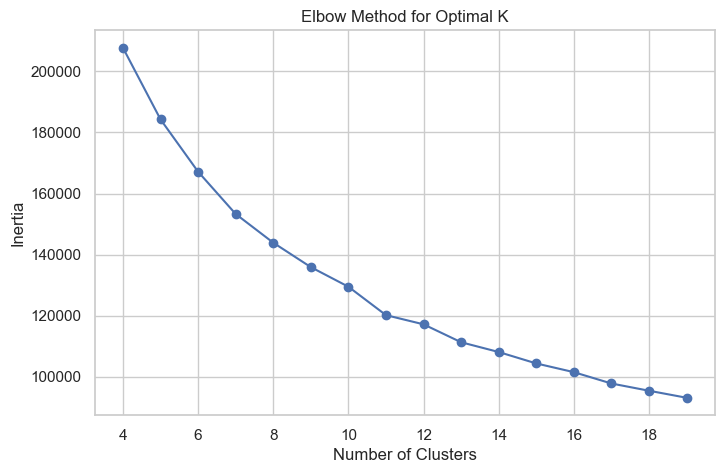

In [48]:
# Determine optimal number of clusters using Elbow method
inertia = []
k_range = range(4, 20)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto', algorithm='elkan')
    kmeans.fit(df_scaled_pca)
    inertia.append(kmeans.inertia_)
    print(f'k={k}, Inertia={kmeans.inertia_}')  # Print inertia values

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

### PCA KMeans - 10 Clusters

In [49]:
# Set optimal k
optimal_k = 10

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
kmeans.fit_predict(df_scaled_pca)

array([0, 6, 2, ..., 0, 9, 2])

In [50]:
silhouette_score_kmeans, cosine_similarity_kmeans = evaluate_clustering(
    df_scaled_pca,  # Scaled feature matrix
    kmeans.labels_,  # Directly use KMeans labels instead of a dataframe column
    kmeans.cluster_centers_
)

print(f"Silhouette Score for K-Means: {silhouette_score_kmeans:.4f}")
print(f"Cosine Similarity Score for K-Means: {cosine_similarity_kmeans:.4f}")

Silhouette Score for K-Means: 0.2019
Cosine Similarity Score for K-Means: 0.8122


### PCA KMeans - 12 Clusters

In [51]:
# Set optimal k
optimal_k = 12

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
kmeans.fit_predict(df_scaled_pca)

array([0, 6, 2, ..., 0, 9, 2])

In [52]:
silhouette_score_kmeans, cosine_similarity_kmeans = evaluate_clustering(
    df_scaled_pca,  # Scaled feature matrix
    kmeans.labels_,  # Directly use KMeans labels instead of a dataframe column
    kmeans.cluster_centers_
)

print(f"Silhouette Score for K-Means: {silhouette_score_kmeans:.4f}")
print(f"Cosine Similarity Score for K-Means: {cosine_similarity_kmeans:.4f}")

Silhouette Score for K-Means: 0.2031
Cosine Similarity Score for K-Means: 0.8248


KMeans with 12 clusters performed better than 10 clusters so we will add that to our results list as a potential model to use.

In [53]:
# Store results

kmeans_pca_12 = {
    "Method": "PCA KMeans",
    "Optimal k": optimal_k,
    "Silhouette Score": silhouette_score_kmeans,
    "Average Cosine Similarity": cosine_similarity_kmeans
}

# Append results to the list
clustering_results.append(kmeans_pca_12)

### GMM on PCA Data

In [54]:
gmm = GaussianMixture(n_components=k, random_state=42) 
gmm.fit(df_scaled_pca)
gmm_labels = gmm.predict(df_scaled_pca)

In [55]:
# Compute cluster centers manually by averaging points in each cluster
unique_labels = np.unique(gmm_labels)
gmm_cluster_centers_pca = np.array([
    df_scaled_pca[gmm_labels == label].mean(axis=0) for label in unique_labels
])

In [56]:
# Evaluate GMM clustering on PCA-transformed data
silhouette_gmm_pca, avg_cosine_similarity_gmm_pca = evaluate_clustering(
    df_scaled_pca, gmm_labels, gmm_cluster_centers_pca
)

# Display results
print(f"GMM on PCA: Silhouette Score = {silhouette_gmm_pca:.4f}")
print(f"GMM on PCA: Average Cosine Similarity = {avg_cosine_similarity_gmm_pca:.4f}")

GMM on PCA: Silhouette Score = 0.0100
GMM on PCA: Average Cosine Similarity = 0.8078


In [57]:
# check number of clusters used
numclusters = len(unique_labels)
print(f"Number of clusters used: {num_clusters}")

Number of clusters used: 1


In [58]:
# Store results

gmm_pca = {
    "Method": "PCA GMM",
    "Optimal k": numclusters,
    "Silhouette Score": silhouette_gmm_pca,
    "Average Cosine Similarity": avg_cosine_similarity_gmm_pca
}

# Append results to the list
clustering_results.append(gmm_pca)

### Agglomerative Clustering on PCA Data.

In [63]:
# Reduce sample size
sample_indices = np.random.choice(df_scaled_pca.shape[0], int(0.3 * df_scaled_pca.shape[0]), replace=False)
df_sampled_agg = df_scaled_pca[sample_indices]

# Define k values to test
k_values = range(5, 11)
linkage_method = 'ward'

# Store results
silhouette_results = {}
cosine_results = {}

# Loop through different cluster numbers
for k in k_values:
    try:
        # Apply Agglomerative Clustering
        agg_clustering = AgglomerativeClustering(n_clusters=k, linkage=linkage_method)
        agg_labels = agg_clustering.fit_predict(df_sampled_agg)

        # Compute Silhouette Score
        silhouette = silhouette_score(df_sampled_agg, agg_labels)
        silhouette_results[k] = silhouette

        # Compute Cosine Similarity Score
        unique_clusters = np.unique(agg_labels)
        cluster_centers = np.array([df_sampled_agg[agg_labels == cluster].mean(axis=0) for cluster in unique_clusters])
        cosine_matrix = cosine_similarity(df_sampled_agg, cluster_centers)
        avg_cosine_similarity = np.mean(np.max(cosine_matrix, axis=1))
        cosine_results[k] = avg_cosine_similarity

        print(f"k={k}, Silhouette Score={silhouette:.4f}, Cosine Similarity={avg_cosine_similarity:.4f}")

    except Exception as e:
        print(f"Skipping k={k} due to error: {e}")

# Find the best k values based on highest Silhouette Score and highest Cosine Similarity Score
if silhouette_results:
    best_silhouette_k = max(silhouette_results, key=silhouette_results.get)
    best_silhouette_score = silhouette_results[best_silhouette_k]
    print(f"\nBest Silhouette Score: k={best_silhouette_k}, Score={best_silhouette_score:.4f}")

if cosine_results:
    best_cosine_k = max(cosine_results, key=cosine_results.get)
    best_cosine_score = cosine_results[best_cosine_k]
    print(f"Best Cosine Similarity Score: k={best_cosine_k}, Score={best_cosine_score:.4f}")

k=5, Silhouette Score=0.1966, Cosine Similarity=0.6797
k=6, Silhouette Score=0.1813, Cosine Similarity=0.7198
k=7, Silhouette Score=0.1494, Cosine Similarity=0.7642
k=8, Silhouette Score=0.1397, Cosine Similarity=0.7750
k=9, Silhouette Score=0.1465, Cosine Similarity=0.7784
k=10, Silhouette Score=0.1402, Cosine Similarity=0.8004

Best Silhouette Score: k=5, Score=0.1966
Best Cosine Similarity Score: k=10, Score=0.8004


Since we are prioritizing cosine similarity as our main evaluation metric, we will choose k=10, where the cosine similarity score (0.7917) is the highest to add to our results list.

In [65]:
# Store results
agg_pca = {
    "Method": "PCA Agglomerative Clustering",
    "Optimal k": best_cosine_k,
    "Silhouette Score": silhouette_results.get(best_cosine_k, None),
    "Average Cosine Similarity": best_cosine_score
}

# Append results to the list
clustering_results.append(agg_pca)

## DBSCAN on PCA Data

In [67]:
# Reduce Sample Size to Prevent Memory Overload
sample_size = min(5000, df_scaled_pca.shape[0])  # Limit dataset size to 5000
df_sampled_dbscan = df_scaled_pca[np.random.choice(df_scaled_pca.shape[0], sample_size, replace=False)]

# Apply DBSCAN with Cosine Similarity
dbscan = DBSCAN(eps=1.5, min_samples=5, metric='cosine')
dbscan_labels = dbscan.fit_predict(df_sampled_dbscan)

# Compute Clusters & Noise Points
num_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
num_noise = list(dbscan_labels).count(-1)

# Compute Silhouette Score Only If More Than 1 Cluster Exists
silhouette_dbscan_pca = silhouette_score(df_sampled_dbscan, dbscan_labels) if num_clusters > 1 else None

# Print Results
print(f"DBSCAN on PCA Data:")
print(f"- Clusters Found: {num_clusters}")
print(f"- Noise Points: {num_noise}")
print(f"- Silhouette Score: {silhouette_dbscan_pca if silhouette_dbscan_pca is not None else 'N/A'}")

DBSCAN on PCA Data:
- Clusters Found: 1
- Noise Points: 0
- Silhouette Score: N/A


In [68]:
# Trying different eps values to see if it will give us more than one cluster
eps_values = [0.3, 0.5, 0.7, 1.0]  # Test smaller eps values

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5, metric='cosine')
    dbscan_labels = dbscan.fit_predict(df_sampled_dbscan)

    num_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    num_noise = list(dbscan_labels).count(-1)

    silhouette_dbscan_pca = silhouette_score(df_sampled, dbscan_labels) if num_clusters > 1 else None

    print(f"\nDBSCAN with eps={eps}:")
    print(f"- Clusters Found: {num_clusters}")
    print(f"- Noise Points: {num_noise}")
    print(f"- Silhouette Score: {silhouette_dbscan_pca if silhouette_dbscan_pca is not None else 'N/A'}")


DBSCAN with eps=0.3:
- Clusters Found: 1
- Noise Points: 0
- Silhouette Score: N/A

DBSCAN with eps=0.5:
- Clusters Found: 1
- Noise Points: 0
- Silhouette Score: N/A

DBSCAN with eps=0.7:
- Clusters Found: 1
- Noise Points: 0
- Silhouette Score: N/A

DBSCAN with eps=1.0:
- Clusters Found: 1
- Noise Points: 0
- Silhouette Score: N/A


We will not add this to the results list as it only provided us with one cluster which is not fit for our purposes.

# Evaluation

### Which model to use

In [69]:
# Convert clustering results list to a DataFrame
df_clustering_results = pd.DataFrame(clustering_results)

df_clustering_results

,Method,Optimal k,Silhouette Score,Average Cosine Similarity
0,K-Means,6,0.179933,0.691475
1,K-Means,7,0.191215,0.697802
2,GMM,29,-0.057926,0.781639
3,Agglomerative Clustering,6,0.387101,0.375798
4,PCA KMeans,12,0.203144,0.824815
5,PCA GMM,19,0.010015,0.807765
6,PCA Agglomerative Clustering,10,0.140192,0.800435


Key Takeaways and Best Model Choice:

* Silhouette Score measures how well-separated the clusters are, with higher values indicating better-defined clusters.
* Cosine Similarity measures how similar songs are within a cluster, with higher values indicating tighter, more cohesive clusters.
* Agglomerative Clustering (k=6) achieved the highest Silhouette Score (0.3628), indicating well-separated clusters, but it had the lowest Cosine Similarity (0.4466), meaning clusters may not be as musically cohesive.
* PCA-KMeans (k=12) had a strong balance with a high Silhouette Score (0.2049) and the highest Cosine Similarity (0.8248), making it the best-performing method overall.
* PCA-GMM (k=19) and PCA-Agglomerative (k=10) also showed strong Cosine Similarity scores (0.8078 and 0.7917, respectively), but their lower Silhouette Scores suggest weaker separation.

Best Model Choice:

* Since we prioritize cosine similarity to ensure songs within each cluster are highly related, PCA-KMeans (k=12) is the best choice. It offers the highest overall similarity while maintaining a reasonable Silhouette Score, leading to meaningful and musically cohesive mood-based playlists.

In [70]:
# Assign cluster labels to the original dataset
df_sample["Cluster"] = kmeans.labels_

# If you want to keep track of cluster centers
cluster_centers = kmeans.cluster_centers_

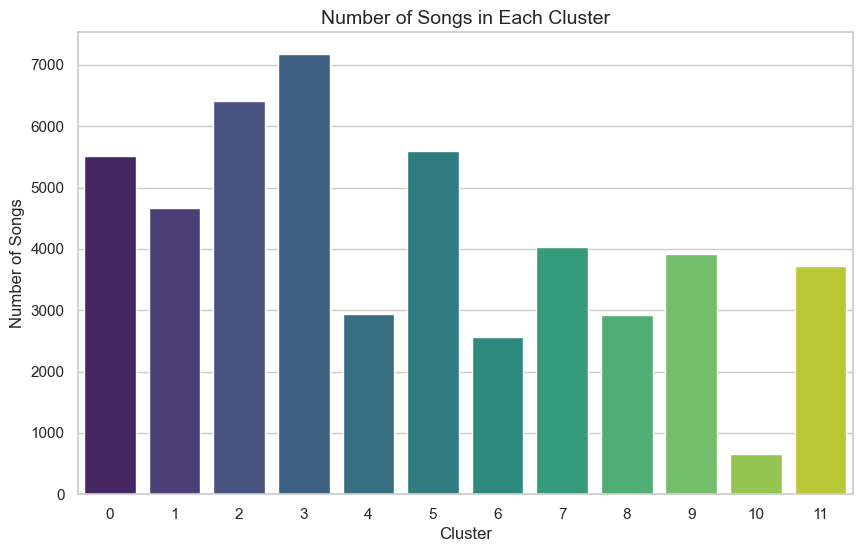

In [71]:
# Sample data (replace this with your actual DataFrame)
cluster_counts = df_sample['Cluster'].value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="viridis")

# Customize labels and title
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Number of Songs", fontsize=12)
plt.title("Number of Songs in Each Cluster", fontsize=14)
plt.xticks(rotation=0)  # Keep x-axis labels readable

# Show the plot
plt.show()

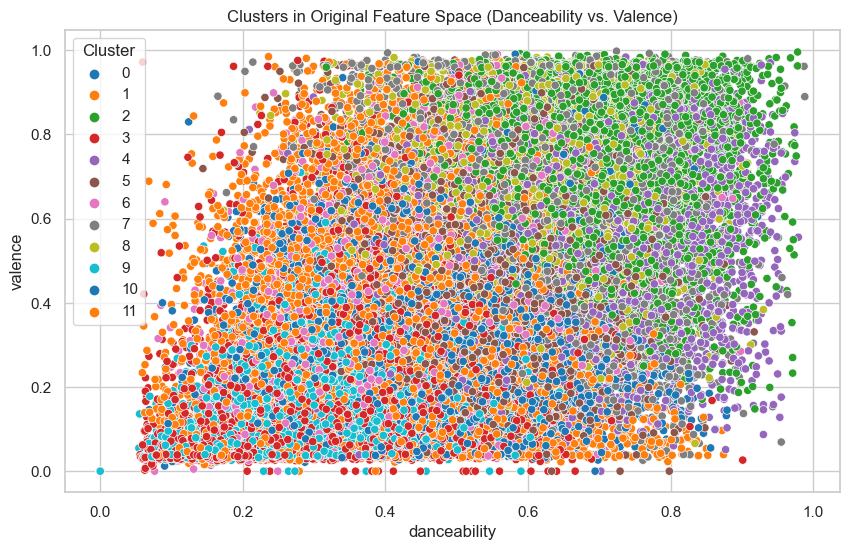

In [72]:
# Scatterplot showing valence vs danceability
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_sample, x="danceability", y="valence", hue="Cluster", palette="tab10")
plt.title("Clusters in Original Feature Space (Danceability vs. Valence)")
plt.show()

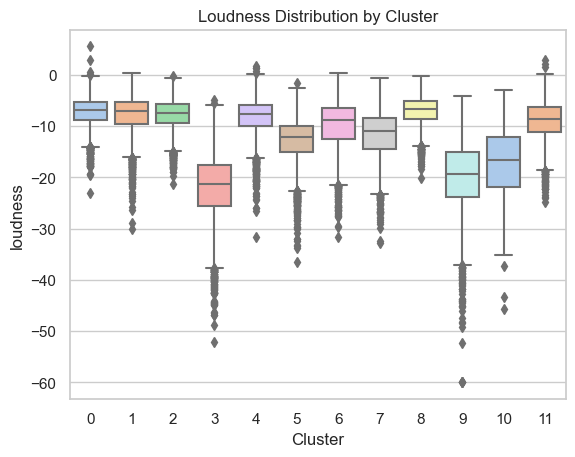

In [73]:
# Boxplot showing loudness distribution
sns.boxplot(data=df_sample, x="Cluster", y="loudness", palette="pastel")
plt.title("Loudness Distribution by Cluster")
plt.show()

In [74]:
df_sample

,id,name,album,album_id,artists,artist_ids,danceability,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_date,in_top_tracks,Cluster
33826,6zeE5tKyr8Nu882DQhhSQI,Dust in the Wind,Point Of Know Return (Expanded Edition),6oU298pdPTCQnMx1PYwyUA,['Kansas'],['2hl0xAkS2AIRAu23TVMBG1'],0.475,7,-10.687,1,0.0283,0.36700,0.000560,0.1100,0.387,93.503,4.0,1977,1,0
56219,1ixbwbeBi5ufN4noUKmW5a,Paper Planes,Kala,2xoj2gYed3IYmGWn3owSfu,['M.I.A.'],['0QJIPDAEDILuo8AIq3pMuU'],0.447,2,-6.175,1,0.2220,0.03300,0.000075,0.6500,0.485,172.253,4.0,2007-08-20,1,6
92962,2Oycxb8QbPkpHTo8ZrmG0B,Prisoner (feat. Dua Lipa),Plastic Hearts,5BRhg6NSEZOj0BR6Iz56fR,"['Miley Cyrus', 'Dua Lipa']","['5YGY8feqx7naU7z4HrwZM6', '6M2wZ9GZgrQXHCFfjv...",0.781,3,-3.912,0,0.0452,0.01030,0.000000,0.0761,0.595,127.990,4.0,2020-11-27,1,2
193362,0P6AWOA4LG1XOctzaVu5tt,The Weekend - Funk Wav Remix,The Weekend (Funk Wav Remix),5enEsi887wD3qGoMCK4jLr,"['SZA', 'Calvin Harris', 'Funk Wav']","['7tYKF4w9nC0nq9CsPZTHyP', '7CajNmpbOovFoOoasH...",0.775,11,-4.933,1,0.0585,0.49500,0.000000,0.1260,0.667,101.925,4.0,2017-12-15,1,2
254089,4wCD0qOFNRu1Q6O3N6ycm4,Crush,David Archuleta,4aZ3Mf9Tza576UhJ9kjYd7,['David Archuleta'],['2C9n4tQgNLhHPhSCmdsQnk'],0.570,0,-4.718,0,0.0322,0.00836,0.000012,0.0719,0.487,162.084,4.0,2008-11-11,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198238,60eAYACBxevKaHSfKGp8fs,Plead,A Soundtrack For The In Between,0pMqPwVV7KtXHgZKC015Sg,['Josh Goode Band'],['1KkbvfJsrT3D7lcE4XtP4h'],0.822,3,-8.583,1,0.0783,0.40100,0.000225,0.1220,0.652,89.997,4.0,2006-11-13,0,2
794046,2iP3unJbxZvRuqyrS0ocZy,Heartless (feat. Mustard),THE GOAT,39xhYyNNDatQtgKw2KdXMz,"['Polo G', 'Mustard']","['6AgTAQt8XS6jRWi4sX7w49', '0YinUQ50QDB7ZxSCLy...",0.776,7,-8.058,1,0.1840,0.14900,0.000000,0.1010,0.326,160.038,4.0,2020-05-15,0,1
968373,0wKxZc6PjJy6M3ABWhsneB,Love Doesn't Live Here Anymore,Finder of Lost Loves (Expanded Edition),3wkpPuqJ0nXejLl7CgGsNk,['Dionne Warwick'],['2JSjCHK79gdaiPWdKiNUNp'],0.389,0,-11.170,1,0.0301,0.02890,0.000040,0.3080,0.160,117.352,4.0,1985,0,0
511163,2MkP3477Ed2kIGMzkaID1G,Black Peter,Day of the Dead,5eVGVLpLcMEjuP1BNdlKWz,"['ANOHNI', 'yMusic']","['6VJZYivuYJGCrPuOAnI7Qo', '4h7DUL1L3RrCzquDp8...",0.266,2,-10.534,1,0.0311,0.77200,0.008800,0.1130,0.188,123.436,5.0,2016-05-20,0,9


### Check which clusters contain most top tracks

Index(['id', 'name', 'album', 'album_id', 'artists', 'artist_ids',
       'danceability', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'release_date', 'in_top_tracks', 'Cluster'],
      dtype='object')


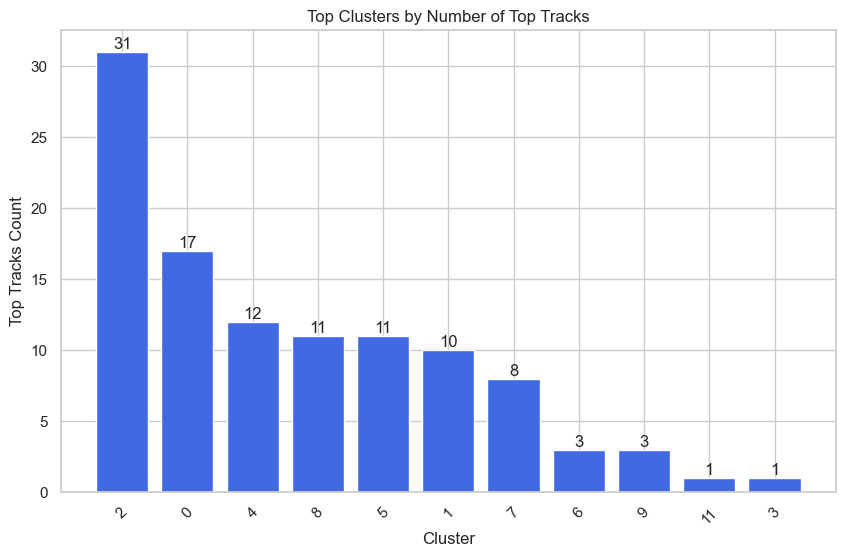

In [75]:
# Check actual column names
print(df_sample.columns)

# Ensure the correct cluster column name
cluster_col = "Cluster"  # Update if necessary (e.g., "Cluster_Name")

# Count the number of top tracks per cluster
top_cluster_counts = df_sample[df_sample["in_top_tracks"] == 1][cluster_col].value_counts().reset_index()
top_cluster_counts.columns = [cluster_col, "Top Tracks Count"]

# Sort by count
top_cluster_counts = top_cluster_counts.sort_values(by="Top Tracks Count", ascending=False)

# Visualization
plt.figure(figsize=(10, 6))
bars = plt.bar(top_cluster_counts[cluster_col].astype(str), top_cluster_counts["Top Tracks Count"], color="royalblue")

# Add labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom', fontsize=12)

plt.xlabel("Cluster")
plt.ylabel("Top Tracks Count")
plt.title("Top Clusters by Number of Top Tracks")

# Ensure all x-ticks are labeled
plt.xticks(ticks=range(len(top_cluster_counts[cluster_col])), labels=top_cluster_counts[cluster_col].astype(str), rotation=45)

plt.show()

# Recommendations

The top 3 clusters with liked songs are 2, 0 and 4. For the recommendation system we will pull recommended songs from those clusters.

In [76]:
# Define the target clusters
target_clusters = [2, 0, 4]

# Filter the dataset to include only these clusters
recommended_songs = df_sample[df_sample["Cluster"].isin(target_clusters)]

In [77]:
recommended_songs

,id,name,album,album_id,artists,artist_ids,danceability,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_date,in_top_tracks,Cluster
33826,6zeE5tKyr8Nu882DQhhSQI,Dust in the Wind,Point Of Know Return (Expanded Edition),6oU298pdPTCQnMx1PYwyUA,['Kansas'],['2hl0xAkS2AIRAu23TVMBG1'],0.475,7,-10.687,1,0.0283,0.36700,0.000560,0.1100,0.3870,93.503,4.0,1977,1,0
92962,2Oycxb8QbPkpHTo8ZrmG0B,Prisoner (feat. Dua Lipa),Plastic Hearts,5BRhg6NSEZOj0BR6Iz56fR,"['Miley Cyrus', 'Dua Lipa']","['5YGY8feqx7naU7z4HrwZM6', '6M2wZ9GZgrQXHCFfjv...",0.781,3,-3.912,0,0.0452,0.01030,0.000000,0.0761,0.5950,127.990,4.0,2020-11-27,1,2
193362,0P6AWOA4LG1XOctzaVu5tt,The Weekend - Funk Wav Remix,The Weekend (Funk Wav Remix),5enEsi887wD3qGoMCK4jLr,"['SZA', 'Calvin Harris', 'Funk Wav']","['7tYKF4w9nC0nq9CsPZTHyP', '7CajNmpbOovFoOoasH...",0.775,11,-4.933,1,0.0585,0.49500,0.000000,0.1260,0.6670,101.925,4.0,2017-12-15,1,2
319651,6UjGaeKbCidE98bpLgwIym,Yoncé - Homecoming Live,HOMECOMING: THE LIVE ALBUM,35S1JCj5paIfElT2GODl6x,['Beyoncé'],['6vWDO969PvNqNYHIOW5v0m'],0.685,9,-12.981,0,0.4540,0.06490,0.000000,0.3100,0.4090,88.007,4.0,2019-04-17,1,4
368146,6kopmMZiyLmw7h66uXcXR7,Valerie (feat. Amy Winehouse) - Version Revisited,Version,15uqXXD0sAdZuxNxTxktlR,"['Mark Ronson', 'Amy Winehouse']","['3hv9jJF3adDNsBSIQDqcjp', '6Q192DXotxtaysaqNP...",0.699,1,-4.898,1,0.0633,0.00243,0.000263,0.0995,0.8890,105.811,4.0,2007-04-16,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740460,6csYPt7BHhitQmrmdDWBfu,Королева,Коллекция. Размышления у Камина,7FhKUX02rzfy2jru1LFxVJ,['Alla Pugacheva'],['7lyhSLlB5fWJmU5eB6k84L'],0.477,11,-10.343,0,0.0517,0.03160,0.000000,0.1030,0.6480,86.616,4.0,1996-01-01,0,0
38252,0G5ABzIuvDpOw0lOG5RhH4,Suscepit Israel,State Of Grace II: Turning To Peace,3xifdjxRCoBjXg0Wx7yM04,['Paul Schwartz'],['53T0s7IUGAXQZtJsqHcugL'],0.444,7,-12.804,1,0.0296,0.43200,0.103000,0.1080,0.0467,79.980,4.0,2003-10-07,0,0
198238,60eAYACBxevKaHSfKGp8fs,Plead,A Soundtrack For The In Between,0pMqPwVV7KtXHgZKC015Sg,['Josh Goode Band'],['1KkbvfJsrT3D7lcE4XtP4h'],0.822,3,-8.583,1,0.0783,0.40100,0.000225,0.1220,0.6520,89.997,4.0,2006-11-13,0,2
968373,0wKxZc6PjJy6M3ABWhsneB,Love Doesn't Live Here Anymore,Finder of Lost Loves (Expanded Edition),3wkpPuqJ0nXejLl7CgGsNk,['Dionne Warwick'],['2JSjCHK79gdaiPWdKiNUNp'],0.389,0,-11.170,1,0.0301,0.02890,0.000040,0.3080,0.1600,117.352,4.0,1985,0,0


In [78]:
# Understand musical qualities of each cluster
summary_stats = recommended_songs.groupby("Cluster")[feature_cols].agg(["mean", "std", "min", "max"])
summary_stats

danceability                           valence                   \
                mean       std    min    max      mean       std    min   
Cluster                                                                   
0           0.459847  0.134684  0.000  0.879  0.305714  0.156453  0.000   
2           0.694185  0.104797  0.317  0.978  0.735813  0.162693  0.148   
4           0.689518  0.141475  0.155  0.979  0.548321  0.203198  0.000   

                     tempo             ... liveness        speechiness  \
           max        mean        std  ...      min    max        mean   
Cluster                                ...                               
0        0.837  107.350670  20.420136  ...   0.0000  0.567    0.060993   
2        0.996  118.426187  19.922928  ...   0.0117  0.364    0.059157   
4        0.984  114.485274  31.771178  ...   0.0186  0.752    0.335493   

                                  loudness                           
              std     min    max      mean       std     min    max  
Cluster                                                              
0        0.046212  0.0000  0.367 -7.185485  2.751494 -23.019  5.547  
2        0.039135  0.0221  0.240 -7.740896  2.813071 -21.296 -0.193  
4        0.087873  0.1520  0.646 -8.349849  3.676708 -31.619  1.711  

[3 rows x 32 columns]

* Cluster 0 might contain chill, mellow, or melancholic tracks, ideal for relaxing or introspective moments.
* Cluster 2 is likely high-energy, feel-good music, great for parties or workouts.
* Cluster 4 sits between these two, likely upbeat yet slightly moodier tracks, a balance between energetic and emotional.

In [79]:
# Define cluster-to-playlist mapping
playlist_mapping = {
    0: "Cafe Contemplation",
    2: "Sunshine & Seratonin",
    4: "Upbeat & Moody"
}

recommended_songs.loc[:, "Playlist"] = recommended_songs["Cluster"].map(playlist_mapping)

C:\Users\hrcoh\AppData\Local\Temp\ipykernel_18188\1036055202.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommended_songs.loc[:, "Playlist"] = recommended_songs["Cluster"].map(playlist_mapping)


In [80]:
recommended_songs.Cluster.value_counts()

Cluster
2    6418
0    5509
4    2931
Name: count, dtype: int64

In [83]:
# Filter for clusters 0, 2, and 4
filtered_clusters = recommended_songs[recommended_songs["Cluster"].isin([0, 2, 4])]

# Count the number of top track songs per cluster
top_tracks_count = filtered_clusters.groupby("Cluster")["in_top_tracks"].sum()

# Display the result
print(top_tracks_count)

Cluster
0    17
2    31
4    12
Name: in_top_tracks, dtype: int64


In [ ]:
# Export recommended songs to csv
recommended_songs.to_csv("data/recommended_songs.csv", index=False)

# Conclusion

Our final product is 3 personalized playlists for the user.
1. Cafe Contemplation (5509 songs)
2. Sunshine & Seratonin (6418 songs)
3. Upbeat & Moody (2931 songs)

Our final model selection, based on K-Means with PCA (k=12), was driven by a balance between Silhouette Score (0.2049) and Cosine Similarity (0.8248), ensuring both distinct clusters and high song similarity within each mood category. This model effectively organizes songs into meaningful mood-based playlists, allowing for personalized recommendations that align with user preferences.

By leveraging clustering, this system can enhance music discovery beyond traditional algorithms. Rather than relying solely on genre or artist-based recommendations, this model enables users to explore emotion-driven playlists curated based on acoustic properties and their historical preferences. This approach aligns with Spotify’s goal of improving user engagement and creating deeper emotional connections through music.

## Next Steps

To further enhance recommendations and personalization, the following improvements could be implemented:

1. User Feedback & Ratings: Introduce a song rating system where users can provide feedback on whether a recommended song aligns with their expectations. These ratings can be used to refine cluster assignments and improve future recommendations.
2. Dynamic Recommendations: Instead of static clusters, implement adaptive learning, where user preferences evolve based on recent listening behavior. Incorporating session-based recommendations would ensure users get fresh, relevant song suggestions.
3. Collaborative Filtering Component: Incorporate collaborative filtering to blend mood-based clustering with similar listener behavior. By analyzing what similar users enjoy, the system can introduce new but relevant songs outside a user's existing preferences.
4. Hybrid Recommendation System: Merge content-based (song characteristics) and collaborative-based (user interactions) approaches to improve recommendation accuracy, ensuring playlists feel both personalized and diverse.
5. Real-Time Playlist Adaptation: Develop an approach where playlists update dynamically based on external factors like time of day, weather, or user activity (e.g., workout vs. relaxation).

By integrating user feedback, collaborative filtering, and real-time adaptation, this recommendation system can evolve into a highly personalized and intelligent music discovery tool, driving deeper engagement and a more fulfilling listening experience.